In [1]:
import numpy as np 
import pandas as pd 
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf,col
from pyspark.sql.types import DoubleType,IntegerType,FloatType
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pylab as plt

In [2]:
spSession = SparkSession.builder.master("local").appName("Spark_CostPrediction").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
import warnings
warnings.filterwarnings('ignore')

22/11/17 02:12:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#baixando o csv e deixando o spark verificar seu schema(atribuir automaticamente)
df = spark.read.options(header='True', inferSchema='True').csv("data/mediapredictionandcost.csv")
df.printSchema()

root
 |-- food_category: string (nullable = true)
 |-- food_department: string (nullable = true)
 |-- food_family: string (nullable = true)
 |-- store_sales(in millions): double (nullable = true)
 |-- store_cost(in millions): double (nullable = true)
 |-- unit_sales(in millions): double (nullable = true)
 |-- promotion_name: string (nullable = true)
 |-- sales_country: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- total_children: double (nullable = true)
 |-- education: string (nullable = true)
 |-- member_card: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- houseowner: string (nullable = true)
 |-- avg_cars_at home(approx): double (nullable = true)
 |-- avg_yearly_income: string (nullable = true)
 |-- num_children_at_home: double (nullable = true)
 |-- brand_name: string (nullable = true)
 |-- SRP: double (nullable = true)
 |-- gross_weight: double (nullable = true)
 |-- net_weight: double (nu

<h2>analise inicial e separacao de dados</h2>

In [4]:
df.columns

['food_category',
 'food_department',
 'food_family',
 'store_sales(in millions)',
 'store_cost(in millions)',
 'unit_sales(in millions)',
 'promotion_name',
 'sales_country',
 'marital_status',
 'gender',
 'total_children',
 'education',
 'member_card',
 'occupation',
 'houseowner',
 'avg_cars_at home(approx)',
 'avg_yearly_income',
 'num_children_at_home',
 'brand_name',
 'SRP',
 'gross_weight',
 'net_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_type',
 'store_city',
 'store_state',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft',
 'coffee_bar',
 'video_store',
 'salad_bar',
 'prepared_food',
 'florist',
 'media_type',
 'cost']

In [5]:
df.toPandas()

22/11/17 02:13:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1428.0000,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,Specialty,Carousel,Non-Consumable,2.76,1.3248,1.0,You Save Days,USA,M,F,...,15321.0,4294.0,2863.0,1.0,0.0,0.0,0.0,0.0,In-Store Coupon,95.25
60424,Specialty,Carousel,Non-Consumable,1.60,496.0000,1.0,Price Cutters,USA,S,F,...,15321.0,4294.0,2863.0,1.0,0.0,0.0,0.0,0.0,Sunday Paper,69.42
60425,Specialty,Carousel,Non-Consumable,5.52,2.5392,2.0,Weekend Markdown,USA,M,M,...,15321.0,4294.0,2863.0,1.0,0.0,0.0,0.0,0.0,"Sunday Paper, Radio, TV",67.51
60426,Specialty,Carousel,Non-Consumable,8.28,2.5668,3.0,Sales Days,Canada,S,M,...,27463.0,4193.0,2795.0,1.0,0.0,0.0,0.0,1.0,Sunday Paper,132.88


In [6]:
#excluindo, se tiver, nulos
df.dropna()

DataFrame[food_category: string, food_department: string, food_family: string, store_sales(in millions): double, store_cost(in millions): double, unit_sales(in millions): double, promotion_name: string, sales_country: string, marital_status: string, gender: string, total_children: double, education: string, member_card: string, occupation: string, houseowner: string, avg_cars_at home(approx): double, avg_yearly_income: string, num_children_at_home: double, brand_name: string, SRP: double, gross_weight: double, net_weight: double, recyclable_package: double, low_fat: double, units_per_case: double, store_type: string, store_city: string, store_state: string, store_sqft: double, grocery_sqft: double, frozen_sqft: double, meat_sqft: double, coffee_bar: double, video_store: double, salad_bar: double, prepared_food: double, florist: double, media_type: string, cost: double]

In [7]:
df.take(2)

[Row(food_category='Breakfast Foods', food_department='Frozen Foods', food_family='Food', store_sales(in millions)=7.36, store_cost(in millions)=2.7232, unit_sales(in millions)=4.0, promotion_name='Bag Stuffers', sales_country='USA', marital_status='M', gender='F', total_children=1.0, education='Partial High School', member_card='Normal', occupation='Skilled Manual', houseowner='Y', avg_cars_at home(approx)=1.0, avg_yearly_income='$10K - $30K', num_children_at_home=1.0, brand_name='Carrington', SRP=1.84, gross_weight=19.7, net_weight=17.7, recyclable_package=1.0, low_fat=0.0, units_per_case=17.0, store_type='Deluxe Supermarket', store_city='Salem', store_state='OR', store_sqft=27694.0, grocery_sqft=18670.0, frozen_sqft=5415.0, meat_sqft=3610.0, coffee_bar=1.0, video_store=1.0, salad_bar=1.0, prepared_food=1.0, florist=1.0, media_type='Daily Paper, Radio', cost=126.62),
 Row(food_category='Breakfast Foods', food_department='Frozen Foods', food_family='Food', store_sales(in millions)=5.5

In [8]:
#separando as variaveis categoricas e numericas iterando o dtypes
categorica= [item[0] for item in df.dtypes if item[1].startswith('string')]
numerica = [item[0] for item in df.dtypes if item[1].startswith('double')]

In [9]:
print(categorica)

['food_category', 'food_department', 'food_family', 'promotion_name', 'sales_country', 'marital_status', 'gender', 'education', 'member_card', 'occupation', 'houseowner', 'avg_yearly_income', 'brand_name', 'store_type', 'store_city', 'store_state', 'media_type']


In [10]:
#separando em categoricas e numericas
dfcat=df.select(*categorica)
dfnum=df.select(*numerica)

In [11]:
#excluindo a variavel avg que contem uma faixa de valores ex:$10K - $30K
dfcat=dfcat.drop("avg_yearly_income")

In [12]:
df.groupBy('food_category').count().show()
#equivalente ao valuecounts

+--------------------+-----+
|       food_category|count|
+--------------------+-----+
|     Breakfast Foods| 1946|
|     Frozen Desserts| 1446|
|       Starchy Foods| 1103|
|        Baking Goods| 1947|
|   Cleaning Supplies|  748|
|                Meat| 3107|
|    Jams and Jellies| 2550|
|       Hot Beverages|  891|
|          Vegetables| 7440|
|               Dairy| 3835|
|         Snack Foods| 6919|
|               Candy| 1538|
|       Decongestants|  396|
|       Canned Shrimp|  182|
|               Bread| 1797|
|             Seafood|  375|
|Carbonated Beverages|  782|
|    Kitchen Products|  969|
|             Candles|  195|
|           Specialty| 1174|
+--------------------+-----+
only showing top 20 rows



In [13]:
#transformando as categoricas em numeros
indexer = StringIndexer(inputCols=[cols for cols in dfcat.columns], 
                   outputCols=[cols + "1" for cols in dfcat.columns])
indexer_fitted = indexer.fit(dfcat)
dfcat2 = indexer_fitted.transform(dfcat)
dfcat2 = dfcat2.drop(*[cols for cols in dfcat.columns])
dfcat2.toPandas()

,food_category1,food_department1,food_family1,promotion_name1,sales_country1,marital_status1,gender1,education1,member_card1,occupation1,houseowner1,brand_name1,store_type1,store_city1,store_state1,media_type1
0,7.0,3.0,0.0,30.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,12.0,1.0,1.0,1.0,0.0
1,7.0,3.0,0.0,14.0,0.0,1.0,1.0,2.0,3.0,0.0,0.0,12.0,1.0,1.0,1.0,0.0
2,7.0,3.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,12.0,1.0,1.0,1.0,0.0
3,7.0,3.0,0.0,14.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,12.0,1.0,1.0,1.0,7.0
4,7.0,3.0,0.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,16.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,16.0,21.0,1.0,28.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,106.0,4.0,15.0,2.0,7.0
60424,16.0,21.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,107.0,4.0,15.0,2.0,6.0
60425,16.0,21.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,106.0,4.0,15.0,2.0,12.0
60426,16.0,21.0,1.0,26.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,106.0,3.0,17.0,5.0,6.0


In [14]:
print(dfcat2)

DataFrame[food_category1: double, food_department1: double, food_family1: double, promotion_name1: double, sales_country1: double, marital_status1: double, gender1: double, education1: double, member_card1: double, occupation1: double, houseowner1: double, brand_name1: double, store_type1: double, store_city1: double, store_state1: double, media_type1: double]


In [15]:
# analisando as viariaveis numericas

In [16]:
#estas variaveis estao como numericas ,mas,sao categoricas
dfnum.groupBy('florist','prepared_food','salad_bar','coffee_bar','video_store','recyclable_package','low_fat').count().show()
dfnumcat=dfnum.select('florist','prepared_food','salad_bar','coffee_bar','video_store','recyclable_package','low_fat')
dfnum=dfnum.drop(*[cols for cols in dfnumcat.columns])
print(dfnumcat)

+-------+-------------+---------+----------+-----------+------------------+-------+-----+
|florist|prepared_food|salad_bar|coffee_bar|video_store|recyclable_package|low_fat|count|
+-------+-------------+---------+----------+-----------+------------------+-------+-----+
|    0.0|          0.0|      0.0|       1.0|        0.0|               1.0|    0.0| 2588|
|    1.0|          0.0|      0.0|       1.0|        0.0|               0.0|    1.0|   89|
|    1.0|          1.0|      1.0|       1.0|        1.0|               1.0|    0.0| 7968|
|    1.0|          1.0|      1.0|       1.0|        0.0|               1.0|    0.0| 2872|
|    0.0|          1.0|      1.0|       0.0|        0.0|               1.0|    1.0| 1174|
|    1.0|          0.0|      0.0|       0.0|        0.0|               1.0|    0.0| 1474|
|    0.0|          0.0|      0.0|       0.0|        0.0|               0.0|    0.0| 3767|
|    1.0|          1.0|      1.0|       1.0|        0.0|               1.0|    1.0| 1587|
|    0.0| 

In [17]:
#juntando (numericas que sao categoricas com as variaveis categoricas ja definidas) 
df1=dfnumcat.toPandas()
df2=dfcat2.toPandas()
df3=pd.concat([df1, df2], axis=1, join='inner')

dfcat2=spark.createDataFrame(df3) 

In [18]:
dfcat2.columns

['florist',
 'prepared_food',
 'salad_bar',
 'coffee_bar',
 'video_store',
 'recyclable_package',
 'low_fat',
 'food_category1',
 'food_department1',
 'food_family1',
 'promotion_name1',
 'sales_country1',
 'marital_status1',
 'gender1',
 'education1',
 'member_card1',
 'occupation1',
 'houseowner1',
 'brand_name1',
 'store_type1',
 'store_city1',
 'store_state1',
 'media_type1']

In [19]:
#variaveis numericas antes de mudar a escala
dfnum.toPandas()

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,net_weight,units_per_case,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,cost
0,7.36,2.7232,4.0,1.0,1.0,1.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,126.62
1,5.52,2.5944,3.0,0.0,4.0,0.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,59.86
2,3.68,1.3616,2.0,4.0,1.0,0.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,84.16
3,3.68,1.1776,2.0,2.0,2.0,2.0,1.84,19.70,17.70,17.0,27694.0,18670.0,5415.0,3610.0,95.78
4,4.08,1428.0000,3.0,0.0,2.0,0.0,1.36,7.12,5.11,29.0,27694.0,18670.0,5415.0,3610.0,50.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,2.76,1.3248,1.0,1.0,1.0,1.0,2.76,19.60,18.60,26.0,22478.0,15321.0,4294.0,2863.0,95.25
60424,1.60,496.0000,1.0,2.0,2.0,0.0,1.60,17.40,15.30,36.0,22478.0,15321.0,4294.0,2863.0,69.42
60425,5.52,2.5392,2.0,1.0,3.0,0.0,2.76,19.60,18.60,26.0,22478.0,15321.0,4294.0,2863.0,67.51
60426,8.28,2.5668,3.0,2.0,4.0,0.0,2.76,19.60,18.60,26.0,34452.0,27463.0,4193.0,2795.0,132.88


In [20]:
#analise estatistica
dfnum.toPandas().describe()

,store_sales(in millions),store_cost(in millions),unit_sales(in millions),total_children,avg_cars_at home(approx),num_children_at_home,SRP,gross_weight,net_weight,units_per_case,store_sqft,grocery_sqft,frozen_sqft,meat_sqft,cost
count,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000,60428.000000
mean,6.541031,714.371465,3.093169,2.533875,2.200271,0.829351,2.115258,13.806433,11.796289,18.860694,27988.477494,19133.799696,5312.852552,3541.846280,99.262366
std,3.463047,1405.516069,0.827677,1.490165,1.109644,1.303424,0.932829,4.622693,4.682986,10.258555,5701.022090,3987.395735,1575.907263,1050.471635,30.011257
min,0.510000,0.163200,1.000000,0.000000,0.000000,0.000000,0.500000,6.000000,3.050000,1.000000,20319.000000,13305.000000,2452.000000,1635.000000,50.790000
25%,3.810000,1.846800,3.000000,1.000000,1.000000,0.000000,1.410000,9.700000,7.710000,10.000000,23593.000000,16232.000000,4746.000000,3164.000000,69.650000
50%,5.940000,3.169200,3.000000,3.000000,2.000000,0.000000,2.130000,13.600000,11.600000,19.000000,27694.000000,18670.000000,5062.000000,3375.000000,98.520000
75%,8.670000,826.000000,4.000000,4.000000,3.000000,1.000000,2.790000,17.700000,16.000000,28.000000,30797.000000,22123.000000,5751.000000,3834.000000,126.620000
max,22.920000,9525.000000,6.000000,5.000000,4.000000,5.000000,3.980000,21.900000,20.800000,36.000000,39696.000000,30351.000000,9184.000000,6122.000000,149.750000


In [21]:
#variavel target
target=dfnum.select("cost")

In [22]:
#escalando as variaveis numericas
dfnum2=dfnum

# UDF para converter coluna para vetor 
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# iterando as colunas
for i in [cols for cols in dfnum2.columns]:
    
    # convertendo coluna para vetor
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler 
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline 
    pipeline = Pipeline(stages=[assembler, scaler])

    # preenchendo pipeline no dataframe
    dfnum2 = pipeline.fit(dfnum2).transform(dfnum2).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

#dropando as colunas anteriores e a coluna target
dfnum2=dfnum2.drop('store_sales(in millions)', 'store_cost(in millions)', 'unit_sales(in millions)',
                   'total_children', 'avg_cars_at home(approx)', 'num_children_at_home', 'SRP',
                   'gross_weight', 'net_weight', 'recyclable_package', 'low_fat', 'units_per_case',
                   'store_sqft', 'grocery_sqft', 'frozen_sqft', 'meat_sqft', 'coffee_bar', 'video_store',
                   'salad_bar', 'prepared_food', 'florist', 'cost','cost_Scaled')

print("After Scaling :")
dfnum2.show(1)

After Scaling :


+-------------------------------+------------------------------+------------------------------+---------------------+-------------------------------+---------------------------+----------+-------------------+-----------------+---------------------+-----------------+-------------------+------------------+----------------+
|store_sales(in millions)_Scaled|store_cost(in millions)_Scaled|unit_sales(in millions)_Scaled|total_children_Scaled|avg_cars_at home(approx)_Scaled|num_children_at_home_Scaled|SRP_Scaled|gross_weight_Scaled|net_weight_Scaled|units_per_case_Scaled|store_sqft_Scaled|grocery_sqft_Scaled|frozen_sqft_Scaled|meat_sqft_Scaled|
+-------------------------------+------------------------------+------------------------------+---------------------+-------------------------------+---------------------------+----------+-------------------+-----------------+---------------------+-----------------+-------------------+------------------+----------------+
|                          0.30

In [23]:
dfnum2.toPandas()

,store_sales(in millions)_Scaled,store_cost(in millions)_Scaled,unit_sales(in millions)_Scaled,total_children_Scaled,avg_cars_at home(approx)_Scaled,num_children_at_home_Scaled,SRP_Scaled,gross_weight_Scaled,net_weight_Scaled,units_per_case_Scaled,store_sqft_Scaled,grocery_sqft_Scaled,frozen_sqft_Scaled,meat_sqft_Scaled
0,0.306,0.000,0.6,0.2,0.25,0.2,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
1,0.224,0.000,0.4,0.0,1.00,0.0,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
2,0.141,0.000,0.2,0.8,0.25,0.0,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
3,0.141,0.000,0.2,0.4,0.50,0.4,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
4,0.159,0.150,0.4,0.0,0.50,0.0,0.247,0.070,0.116,0.800,0.381,0.315,0.440,0.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60423,0.100,0.000,0.0,0.2,0.25,0.2,0.649,0.855,0.876,0.714,0.111,0.118,0.274,0.274
60424,0.049,0.052,0.0,0.4,0.50,0.0,0.316,0.717,0.690,1.000,0.111,0.118,0.274,0.274
60425,0.224,0.000,0.2,0.2,0.75,0.0,0.649,0.855,0.876,0.714,0.111,0.118,0.274,0.274
60426,0.347,0.000,0.4,0.4,1.00,0.0,0.649,0.855,0.876,0.714,0.729,0.831,0.259,0.259


<h2>analisando graficamente e limpando os dados</h2>

<AxesSubplot:>

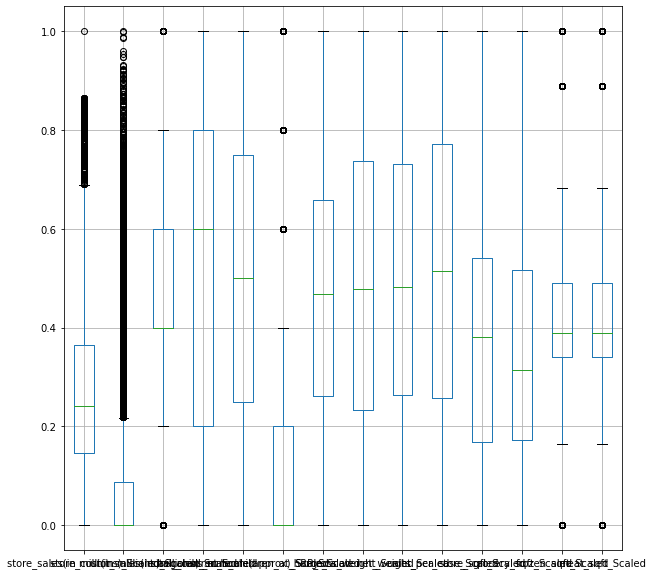

In [24]:
data=dfnum2.toPandas()
data.boxplot(figsize=(10, 10))
# as 2 primeiras variaveis tem bastante outliers

In [25]:
#verificando a ocorrencia das variaveis em ordem decrescente
dfnum2.groupBy("store_sales(in millions)_Scaled").count().orderBy('count', ascending=False).show(30)
dfnum2.groupBy("store_cost(in millions)_Scaled").count().orderBy('count', ascending=False).show(30)

+-------------------------------+-----+
|store_sales(in millions)_Scaled|count|
+-------------------------------+-----+
|                          0.332|  399|
|                          0.241|  344|
|                          0.183|  338|
|                          0.102|  325|
|                          0.224|  324|
|                          0.324|  314|
|                          0.202|  311|
|                           0.22|  300|
|                            0.3|  296|
|                          0.232|  294|
|                          0.286|  284|
|                          0.191|  284|
|                          0.199|  280|
|                          0.216|  278|
|                          0.308|  277|
|                          0.207|  273|
|                          0.218|  270|
|                          0.225|  269|
|                          0.372|  268|
|                          0.141|  262|
|                            0.1|  261|
|                          0.274|  261|


+------------------------------+-----+
|store_cost(in millions)_Scaled|count|
+------------------------------+-----+
|                           0.0|40752|
|                         0.001| 3302|
|                         0.159|  121|
|                         0.215|  113|
|                         0.128|   93|
|                         0.144|   92|
|                         0.247|   89|
|                         0.212|   89|
|                         0.181|   85|
|                         0.166|   84|
|                         0.207|   83|
|                         0.317|   80|
|                         0.163|   80|
|                         0.111|   77|
|                         0.225|   77|
|                         0.249|   76|
|                         0.291|   74|
|                         0.203|   73|
|                         0.121|   72|
|                         0.185|   72|
|                         0.326|   72|
|                         0.108|   71|
|                        

In [26]:
#dropando a variavel,com 40000 zeros
dfnum2=dfnum2.drop("store_cost(in millions)_Scaled")

In [27]:
#excluindo 1 porcento de cada faixa para tirar os outliers
df=dfnum2.toPandas()
q1=df["store_sales(in millions)_Scaled"].quantile(0.99)
q2=df["store_sales(in millions)_Scaled"].quantile(0.01)
df = df[(df["store_sales(in millions)_Scaled"] <= q1) & (df["store_sales(in millions)_Scaled"] >= q2)]
dfnum2=spark.createDataFrame(df) 

22/11/17 02:16:01 WARN TaskSetManager: Stage 73 contains a task of very large size (1509 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:>

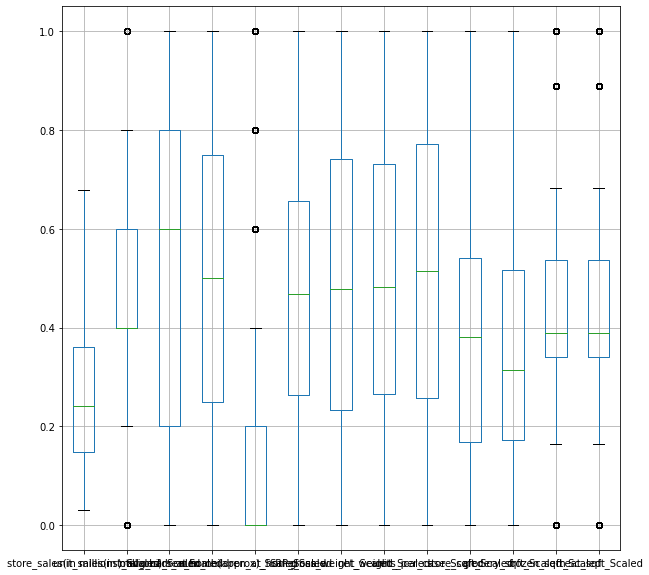

In [28]:
data=dfnum2.toPandas()
data.boxplot(figsize=(10, 10))

In [29]:
dfnum2.toPandas()

22/11/17 02:16:04 WARN TaskSetManager: Stage 74 contains a task of very large size (1509 KiB). The maximum recommended task size is 1000 KiB.


,store_sales(in millions)_Scaled,unit_sales(in millions)_Scaled,total_children_Scaled,avg_cars_at home(approx)_Scaled,num_children_at_home_Scaled,SRP_Scaled,gross_weight_Scaled,net_weight_Scaled,units_per_case_Scaled,store_sqft_Scaled,grocery_sqft_Scaled,frozen_sqft_Scaled,meat_sqft_Scaled
0,0.306,0.6,0.2,0.25,0.2,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
1,0.224,0.4,0.0,1.00,0.0,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
2,0.141,0.2,0.8,0.25,0.0,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
3,0.141,0.2,0.4,0.50,0.4,0.385,0.862,0.825,0.457,0.381,0.315,0.440,0.440
4,0.159,0.4,0.0,0.50,0.0,0.247,0.070,0.116,0.800,0.381,0.315,0.440,0.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59246,0.100,0.0,0.2,0.25,0.2,0.649,0.855,0.876,0.714,0.111,0.118,0.274,0.274
59247,0.049,0.0,0.4,0.50,0.0,0.316,0.717,0.690,1.000,0.111,0.118,0.274,0.274
59248,0.224,0.2,0.2,0.75,0.0,0.649,0.855,0.876,0.714,0.111,0.118,0.274,0.274
59249,0.347,0.4,0.4,1.00,0.0,0.649,0.855,0.876,0.714,0.729,0.831,0.259,0.259


In [30]:
#normalizados os dados, vamos juntar tudo
df1=dfnum2.toPandas()
df2=dfcat2.toPandas()
df3=target.toPandas()

df=pd.concat([df1, df2,df3], axis=1, join='inner')

dffinal=spark.createDataFrame(df) 

22/11/17 02:16:04 WARN TaskSetManager: Stage 75 contains a task of very large size (1509 KiB). The maximum recommended task size is 1000 KiB.
22/11/17 02:16:05 WARN TaskSetManager: Stage 76 contains a task of very large size (2720 KiB). The maximum recommended task size is 1000 KiB.


In [31]:
dffinal.toPandas()

22/11/17 02:16:06 WARN TaskSetManager: Stage 78 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


,store_sales(in millions)_Scaled,unit_sales(in millions)_Scaled,total_children_Scaled,avg_cars_at home(approx)_Scaled,num_children_at_home_Scaled,SRP_Scaled,gross_weight_Scaled,net_weight_Scaled,units_per_case_Scaled,store_sqft_Scaled,...,education1,member_card1,occupation1,houseowner1,brand_name1,store_type1,store_city1,store_state1,media_type1,cost
0,0.306,0.6,0.2,0.25,0.2,0.385,0.862,0.825,0.457,0.381,...,0.0,1.0,1.0,0.0,12.0,1.0,1.0,1.0,0.0,126.62
1,0.224,0.4,0.0,1.00,0.0,0.385,0.862,0.825,0.457,0.381,...,2.0,3.0,0.0,0.0,12.0,1.0,1.0,1.0,0.0,59.86
2,0.141,0.2,0.8,0.25,0.0,0.385,0.862,0.825,0.457,0.381,...,0.0,1.0,2.0,1.0,12.0,1.0,1.0,1.0,0.0,84.16
3,0.141,0.2,0.4,0.50,0.4,0.385,0.862,0.825,0.457,0.381,...,1.0,0.0,2.0,0.0,12.0,1.0,1.0,1.0,7.0,95.78
4,0.159,0.4,0.0,0.50,0.0,0.247,0.070,0.116,0.800,0.381,...,0.0,0.0,1.0,1.0,16.0,1.0,1.0,1.0,5.0,50.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59246,0.100,0.0,0.2,0.25,0.2,0.649,0.855,0.876,0.714,0.111,...,1.0,0.0,1.0,0.0,32.0,1.0,10.0,5.0,12.0,77.24
59247,0.049,0.0,0.4,0.50,0.0,0.316,0.717,0.690,1.000,0.111,...,0.0,0.0,1.0,0.0,34.0,1.0,10.0,5.0,6.0,138.18
59248,0.224,0.2,0.2,0.75,0.0,0.649,0.855,0.876,0.714,0.111,...,1.0,3.0,3.0,0.0,31.0,1.0,10.0,5.0,4.0,144.54
59249,0.347,0.4,0.4,1.00,0.0,0.649,0.855,0.876,0.714,0.729,...,2.0,0.0,0.0,1.0,31.0,1.0,10.0,5.0,7.0,75.22


22/11/17 02:16:08 WARN TaskSetManager: Stage 79 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


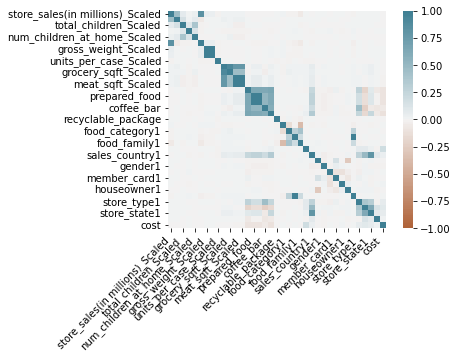

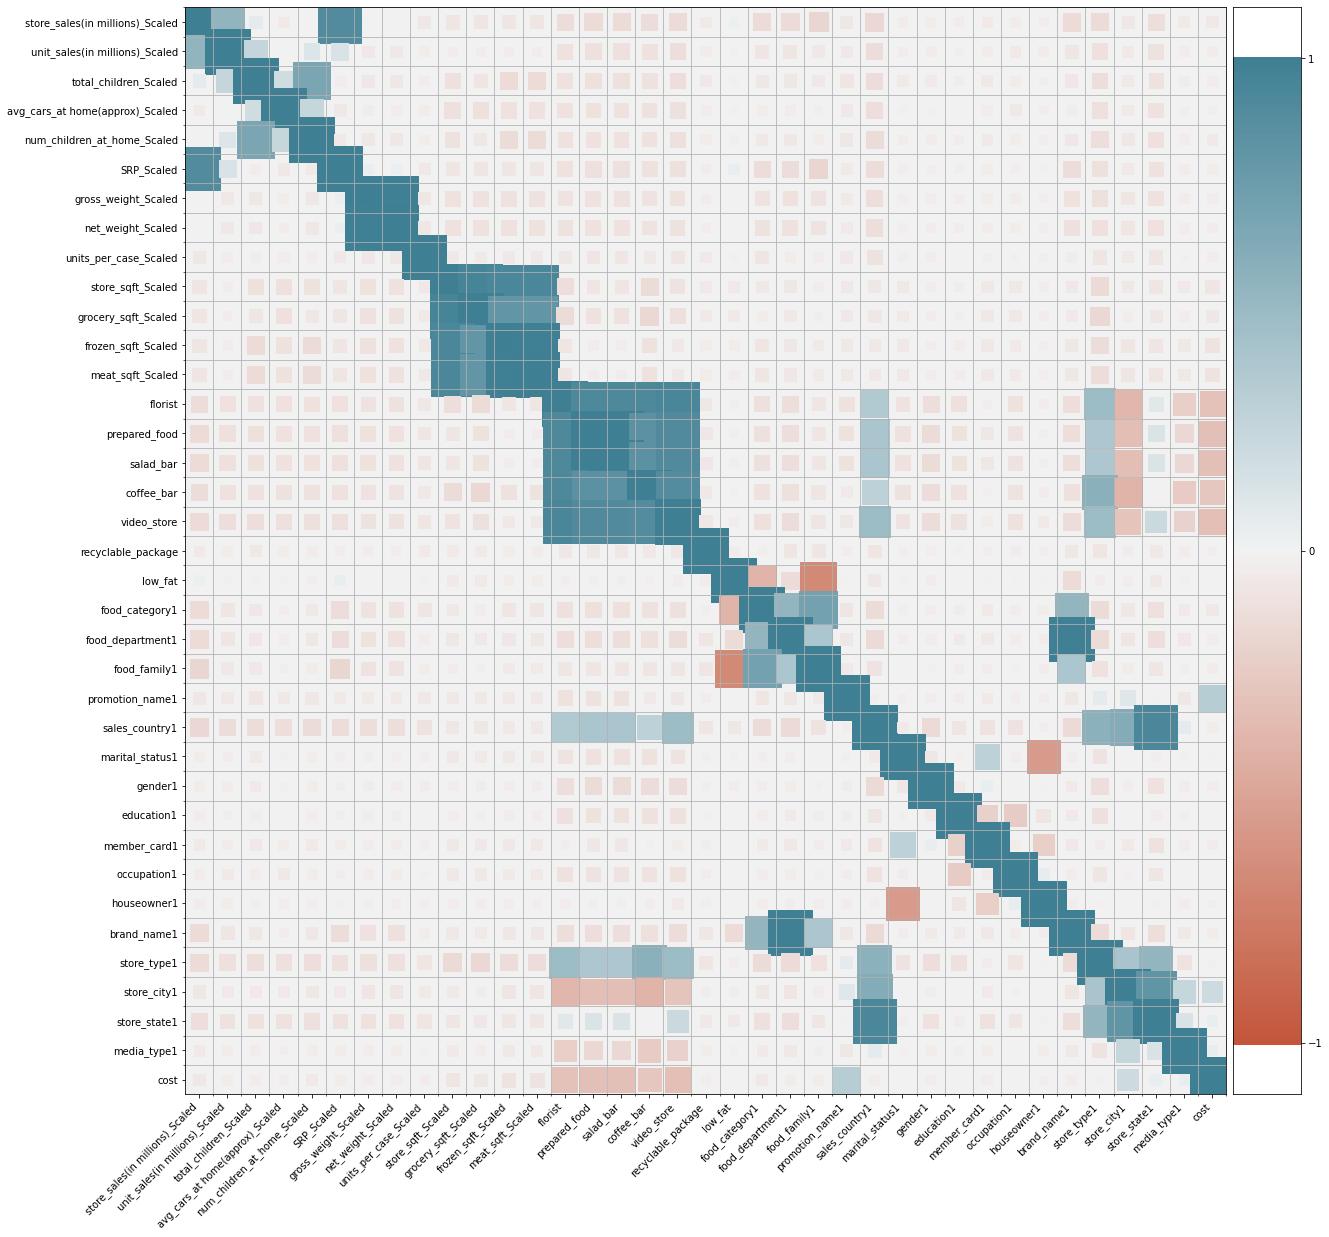

In [32]:
#!pip install heatmapz
#mapa de correlacao
from heatmap import heatmap, corrplot
import seaborn as sns


corr = dffinal.toPandas()
corr = corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.figure(figsize=(20, 20))
corrplot(corr.corr(), size_scale=2000);

22/11/17 02:16:13 WARN TaskSetManager: Stage 80 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


array([[<AxesSubplot:title={'center':'store_sales(in millions)_Scaled'}>,
        <AxesSubplot:title={'center':'unit_sales(in millions)_Scaled'}>,
        <AxesSubplot:title={'center':'total_children_Scaled'}>,
        <AxesSubplot:title={'center':'avg_cars_at home(approx)_Scaled'}>,
        <AxesSubplot:title={'center':'num_children_at_home_Scaled'}>,
        <AxesSubplot:title={'center':'SRP_Scaled'}>],
       [<AxesSubplot:title={'center':'gross_weight_Scaled'}>,
        <AxesSubplot:title={'center':'net_weight_Scaled'}>,
        <AxesSubplot:title={'center':'units_per_case_Scaled'}>,
        <AxesSubplot:title={'center':'store_sqft_Scaled'}>,
        <AxesSubplot:title={'center':'grocery_sqft_Scaled'}>,
        <AxesSubplot:title={'center':'frozen_sqft_Scaled'}>],
       [<AxesSubplot:title={'center':'meat_sqft_Scaled'}>,
        <AxesSubplot:title={'center':'florist'}>,
        <AxesSubplot:title={'center':'prepared_food'}>,
        <AxesSubplot:title={'center':'salad_bar'}>,
    

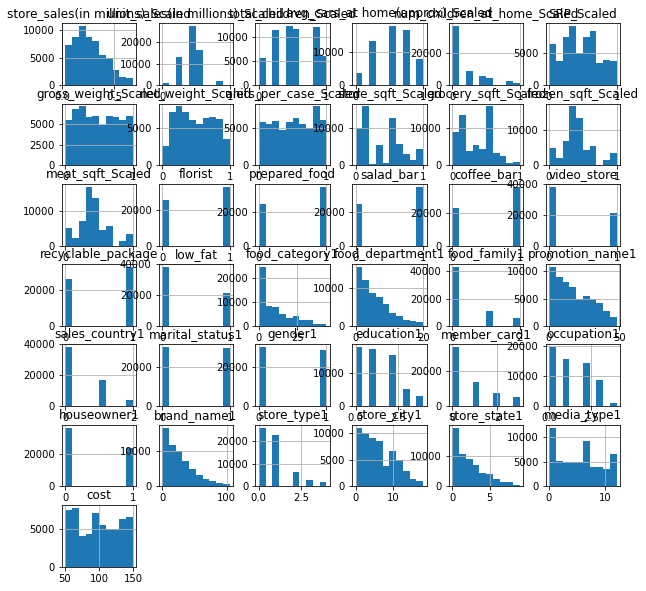

In [33]:
#histograma das variaveis numericas
data=dffinal.toPandas()
data.hist(figsize=(10, 10))

In [34]:
#Vamos vetorizar para passar o modelo
vetor = VectorAssembler(inputCols = [*[cols for cols in dffinal.columns]], outputCol = "features")
df = vetor.transform(dffinal)
df = df.select(["features", "cost"])
df.show(3)

22/11/17 02:16:20 WARN TaskSetManager: Stage 81 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+------+
|            features|  cost|
+--------------------+------+
|[0.306,0.6,0.2,0....|126.62|
|[0.224,0.4,0.0,1....| 59.86|
|[0.141,0.2,0.8,0....| 84.16|
+--------------------+------+
only showing top 3 rows



In [35]:
#separando em treino e teste
splits = df.randomSplit([0.7, 0.3])
treino = splits[0]
teste= splits[1]

<h2>modelo de regressao linear</h2>

In [36]:
#treinando modelo de regressao linear
lr = LinearRegression(featuresCol = 'features', labelCol='cost', maxIter=10, regParam=0.1, elasticNetParam=0.4,solver="auto")
lr_model = lr.fit(treino)
print("coeficientes: " + str(lr_model.coefficients))
print("intercepto: " + str(lr_model.intercept))

22/11/17 02:16:21 WARN TaskSetManager: Stage 82 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:24 WARN TaskSetManager: Stage 83 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


coeficientes: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9966681378710402]
intercepto: 0.3305612724372788


In [37]:
#avaliacao
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.099792
r2: 0.999989


In [38]:
print(trainingSummary.residuals.show())

22/11/17 02:16:26 WARN TaskSetManager: Stage 84 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
+--------------------+
|           residuals|
+--------------------+
|  0.1319345096836173|
|0.014786237229401422|
|-0.01156879221066...|
| 0.13380035247584487|
|-0.03815705199977515|
|0.008755566775988655|
|0.008755566775988655|
|  0.1597888770817235|
|  0.1460282864891269|
|-0.05804826890965842|
| -0.1527397906146959|
|0.008755566775988655|
|  0.1460282864891269|
|-0.14411026770068958|
|0.008755566775988655|
| 0.12230542813094303|
|-0.15124045265666552|
|-0.05804826890965842|
| 0.12230542813094303|
|-0.05804826890965842|
+--------------------+
only showing top 20 rows

None


<h2>random forest</h2>

In [39]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="cost", featuresCol="features")
modelo=rf.fit(treino)

22/11/17 02:16:27 WARN TaskSetManager: Stage 85 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.
22/11/17 02:16:27 WARN TaskSetManager: Stage 86 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:29 WARN TaskSetManager: Stage 87 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:31 WARN TaskSetManager: Stage 89 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:34 WARN TaskSetManager: Stage 91 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:35 WARN TaskSetManager: Stage 93 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:37 WARN TaskSetManager: Stage 95 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


22/11/17 02:16:39 WARN TaskSetManager: Stage 97 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


In [40]:
avaliador = RegressionEvaluator(predictionCol="prediction", labelCol="cost", metricName="r2")

In [41]:
previsao=modelo.transform(teste)

In [42]:
print('R2:', avaliador.evaluate(previsao))

22/11/17 02:16:40 WARN TaskSetManager: Stage 99 contains a task of very large size (4288 KiB). The maximum recommended task size is 1000 KiB.


R2: 0.9654781684742475


In [43]:
#usando o grid builder para tunar os hyperparametros
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

parametros = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [5, 8, 10])
               .addGrid(rf.maxBins, [10, 50, 100])
               .addGrid(rf.numTrees, [5, 10, 20])
             .build())

In [44]:
#fazendo a cross validation com 5 folds
cross = CrossValidator(estimator = rf,
                      estimatorParamMaps = parametros,
                      evaluator = avaliador,
                      numFolds = 5)

In [45]:
sc.setLogLevel("FATAL")
modelos_cross = cross.fit(treino)

In [46]:
previsao_cross = modelos_cross.transform(teste)

In [47]:
avaliador_cross = RegressionEvaluator(predictionCol="prediction", labelCol="cost", metricName="r2")

In [48]:
print('R2:', avaliador_cross.evaluate(previsao_cross))

R2: 0.999253121649281


In [49]:
avaliador_cross2 = RegressionEvaluator(predictionCol="prediction", labelCol="cost", metricName="mse")
print('MSE', avaliador_cross2.evaluate(previsao_cross))

MSE 0.6809184170797631


In [50]:
print("maxDepth",modelos_cross.bestModel.getOrDefault("maxDepth"))
print("maxBins",modelos_cross.bestModel.getOrDefault("maxBins"))
print("numTrees",modelos_cross.bestModel.getOrDefault("numTrees"))

maxDepth 10
maxBins 50
numTrees 20


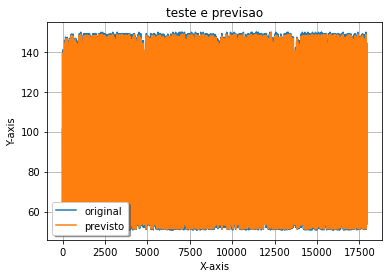

In [51]:
x_ax = range(0, previsao_cross.count())
y_pred=previsao_cross.select("prediction").collect()
y_orig=previsao_cross.select("cost").collect()
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="previsto")
plt.title("teste e previsao")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 